# **Import Libraires**

In [16]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time

In [17]:
import torch
import torchvision
from torch import optim
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import multiprocess
import psutil

# **Data Preprocessing**

(512, 640, 3)


(-0.5, 639.5, 511.5, -0.5)

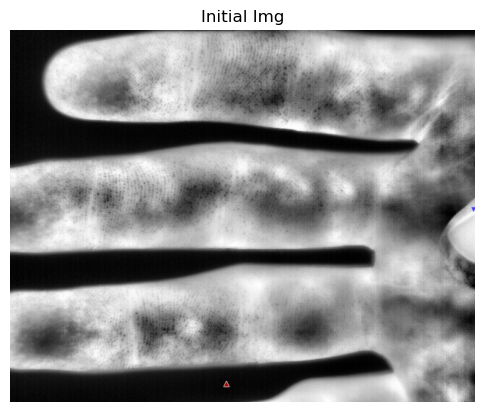

In [18]:
# Import data 
image_path = '/Users/rickysu/Projects/sweatPoresActivation/input_images/raw/8.bmp'
img = cv2.imread(image_path)

print(img.shape)

# show the image 
plt.figure(figsize = (6, 6))
plt.imshow(img, cmap = 'gray')
plt.title("Initial Img")
plt.axis("off")

## **Apply Transformation**
Every thing in Deep Learning is in the form of Tensors. Converting images to tensors is essential for compatibility with deep learning frameworks. Additionally we should also normalized the input images which helps ensure consistency in the input distribution, so that all the tensors are in the same range of [-1, 1]. We can use the method providied by **torchvision.transforms** to do this. 

In [12]:
trans = transforms.Compose([
    transforms.ToTensor(),  # Converting img to tensors for the data loader.
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # scale the pixel values of the image between -1 and 1
])

In [34]:
train_data = trans(img) # apply transformation
print(train_data.shape)

torch.Size([3, 512, 640])


## **Batching Data and Shuffling**


In [30]:
train_loader = DataLoader(train_data,  batch_size=17, shuffle=True, num_workers=4) 
print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [24]:
batch = next(iter(train_loader))
print(len(batch))

3


In [33]:
batch_images, batch_labels, additional_value = next(iter(train_loader))
batch = next(iter(train_loader))
batch_images = batch[0]
print(batch_images.shape)
batch_labels = batch[1]
print(batch_labels)
print(batch[2])

torch.Size([512, 640])
tensor([[-0.9529, -0.9529, -0.9373,  ..., -0.9922, -0.9843, -0.9843],
        [-0.9137, -0.9294, -0.9373,  ..., -0.9608, -0.9608, -0.9608],
        [-0.8902, -0.9059, -0.9294,  ..., -0.9451, -0.9529, -0.9529],
        ...,
        [-0.9608, -0.9529, -0.9373,  ..., -0.4118, -0.3882, -0.5137],
        [-0.9765, -0.9608, -0.9373,  ..., -0.4275, -0.4118, -0.6078],
        [-0.9922, -0.9686, -0.9451,  ..., -0.4980, -0.3882, -0.4824]])
tensor([[-0.9529, -0.9529, -0.9373,  ..., -0.9922, -0.9843, -0.9843],
        [-0.9137, -0.9294, -0.9373,  ..., -0.9608, -0.9608, -0.9608],
        [-0.8902, -0.9059, -0.9294,  ..., -0.9451, -0.9529, -0.9529],
        ...,
        [-0.9608, -0.9529, -0.9373,  ..., -0.4118, -0.3882, -0.5137],
        [-0.9765, -0.9608, -0.9373,  ..., -0.4275, -0.4118, -0.6078],
        [-0.9922, -0.9686, -0.9451,  ..., -0.4980, -0.3882, -0.4824]])
